# Initialisation

In [ ]:
import nltk
from nltk import Text
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords, reuters
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import FreqDist
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
stop_words = set(stopwords.words("english"))
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Récupération des données.

In [ ]:
user_reviews = pd.read_table('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-05-05/user_reviews.tsv')
critic = pd.read_table('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-05-05/critic.tsv')

Voici les deux tables récupérées : 

In [ ]:
user_reviews

,grade,user_name,text,date
0,4,mds27272,My gf started playing before me. No option to ...,2020-03-20
1,5,lolo2178,"While the game itself is great, really relaxin...",2020-03-20
2,0,Roachant,My wife and I were looking forward to playing ...,2020-03-20
3,0,Houndf,We need equal values and opportunities for all...,2020-03-20
4,0,ProfessorFox,BEWARE! If you have multiple people in your h...,2020-03-20
...,...,...,...,...
2994,1,TakezoShinmen,1 Island for console limitation.I cannot play ...,2020-05-03
2995,1,Pikey17,"Per giocare con figli o fidanzate, mogli o per...",2020-05-03
2996,0,Lemmeadem,One island per console is a pathetic limitatio...,2020-05-03
2997,2,TandemTester938,Even though it seems like a great game with ma...,2020-05-03


In [ ]:
critic

,grade,publication,text,date
0,100,Pocket Gamer UK,"Animal Crossing; New Horizons, much like its p...",2020-03-16
1,100,Forbes,Know that if you’re overwhelmed with the world...,2020-03-16
2,100,Telegraph,"With a game this broad and lengthy, there’s mo...",2020-03-16
3,100,VG247,Animal Crossing: New Horizons is everything I ...,2020-03-16
4,100,Nintendo Insider,"Above all else, Animal Crossing: New Horizons ...",2020-03-16
...,...,...,...,...
102,90,Impulsegamer,Animal Crossing New Horizons is pure fun and p...,2020-04-16
103,90,PLAY! Zine,Animal Crossing: New Horizons is a definitive ...,2020-04-17
104,95,GameGrin,New Horizons is simply the best Animal Crossin...,2020-04-22
105,90,NF Magazine,I can't wait to see what the future will hold....,2020-05-01


# Fonctions utiles

In [ ]:
def tokenizeReview(text) : 
  raw_tokens = word_tokenize(text)
  tokens = []
  for i in range(0,len(raw_tokens)-1) :
    if len(raw_tokens[i]) > 2 and raw_tokens[i] not in stop_words : 
      tokens.append(raw_tokens[i].lower())
  return tokens

In [ ]:
def returnWordCount(tokens) :
  return nltk.FreqDist(tokens)

In [ ]:
def returnMostCommon(number, tokens) :
  count = nltk.FreqDist(tokens)
  return count.most_common(number)

In [ ]:
def returnMostCommonDict(number, tokens, grade, sentiment) :
  count = returnMostCommon(number,tokens)
  keys = []
  values = []
  grade = [grade for i in range(number)]
  sentiment = [sentiment for i in range(number)]
  for word in count : 
    keys.append(word[0])
    values.append(word[1])
  return {'word' : keys, 'count' : values, 'grade' : grade, 'sentiment' : sentiment}

In [ ]:
def returnMostCommonDF(number, tokens) :
  return pd.DataFrame(returnMostCommonDict(number,tokens))

In [ ]:
def filterReviews(grade : int, user_reviews):
  user_reviews_filtered = user_reviews[user_reviews["grade"] == grade]
  return user_reviews_filtered

In [ ]:
def getGradeReviewsTokens(grade : int, user_reviews) : 
  global_review_token_list = []
  filtered_reviews = filterReviews(grade, user_reviews)
  for review in filtered_reviews["text"] : 
    sentiment = sia.polarity_scores(review)["compound"]
    review_tokens = tokenizeReview(review)
    global_review_token_list.extend(review_tokens)
  return global_review_token_list, sentiment

In [ ]:
#MostCommonWordDistribution
def MCWD(number, user_reviews) : 
  distribution = []
  for grade in range(1,11) : 
    words, sentiment = getGradeReviewsTokens(grade,user_reviews)
    most_common_words = returnMostCommonDict(number,words,grade)
    for word in most_common_words : 
      if word in distribution : 
        distribution[word] += most_common_words[word]
      else : 
        distribution[word] = most_common_words[word]
  return distribution

In [ ]:
#MostCommonWordDistributionByGrade
def MCWDBG(number, user_reviews) : 
  distribution = []
  for grade in range(11) : 
    words, sentiment = getGradeReviewsTokens(grade,user_reviews)
    distribution.append(returnMostCommonDict(number,words, grade, sentiment))
  return distribution

In [ ]:
def mergeDictKeys(dict_list) : 
  count_list = []
  word_list = []
  grade_list = []
  sentiment_list=[]
  for element in dict_list :
    count_list.extend(element["count"])
    word_list.extend(element["word"])
    grade_list.extend(element["grade"])
    sentiment_list.extend(element["sentiment"])
  return {'word' : word_list, 'count' : count_list, 'grade' : grade_list, 'sentiment' : sentiment_list}

# Quelques Données

In [ ]:
count = MCWDBG(5,user_reviews)
word_count_by_grade = pd.DataFrame(mergeDictKeys(count))

In [ ]:
word_count_by_grade

,word,count,grade,sentiment
0,game,2958,0,-0.3612
1,island,1765,0,-0.3612
2,one,1404,0,-0.3612
3,switch,1044,0,-0.3612
4,play,1018,0,-0.3612
5,game,887,1,0.3182
6,island,402,1,0.3182
7,one,298,1,0.3182
8,play,283,1,0.3182
9,n't,249,1,0.3182


Les mots en fonction de leur fréquence d'apparition dans des critiques de notes différentes.

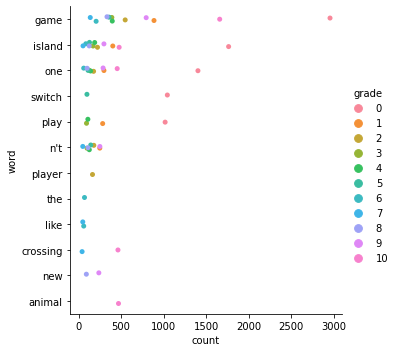

In [ ]:
sns.catplot(x="count", y= "word", hue = "grade",data=word_count_by_grade)

La fréquence d'apparition en fonction de la note attribuée des différents mots.

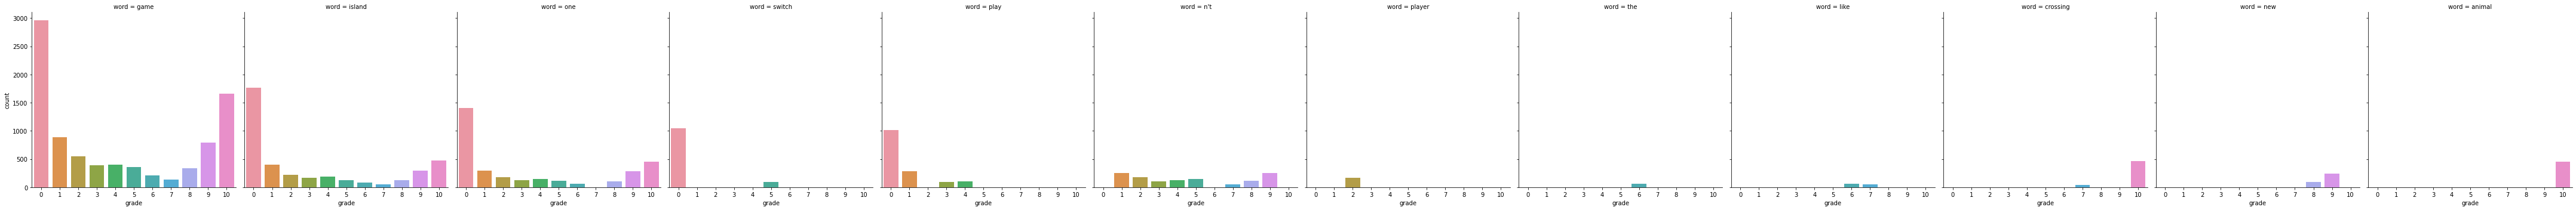

In [ ]:
sns.catplot(x="grade", y= "count", col = "word",kind = "bar",data=word_count_by_grade)

Le sentiment général de la critique en fonction de la note attribuée pour différents mots.

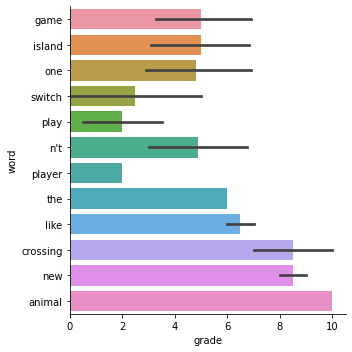

In [ ]:
sns.catplot(x="grade", y= "word",kind = "bar", data=word_count_by_grade)

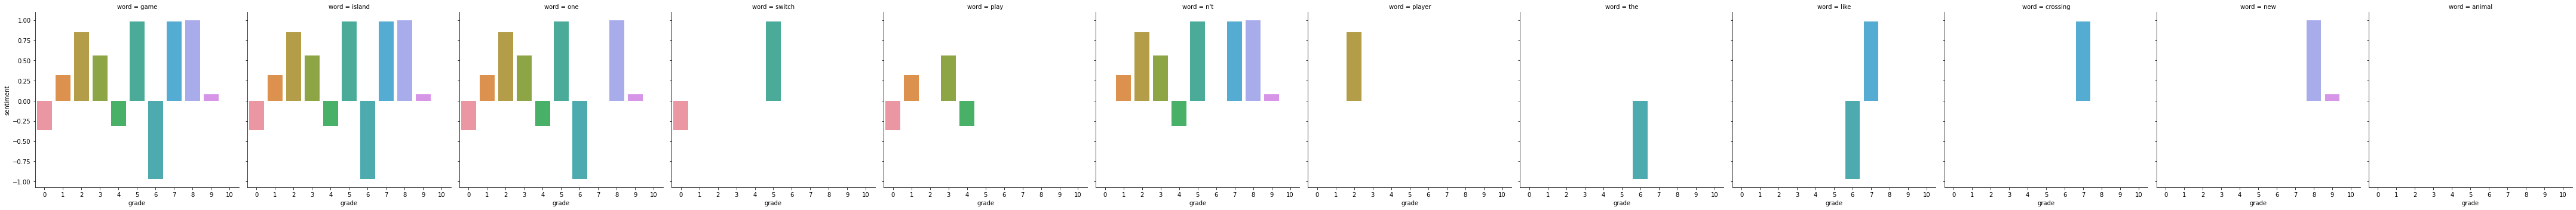

In [ ]:
sns.catplot(x="grade", y= "sentiment",col="word",kind = "bar", data=word_count_by_grade)

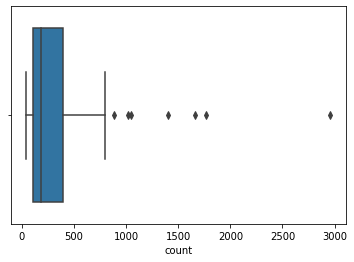

In [ ]:
sns.boxplot(x="count", data = word_count_by_grade)

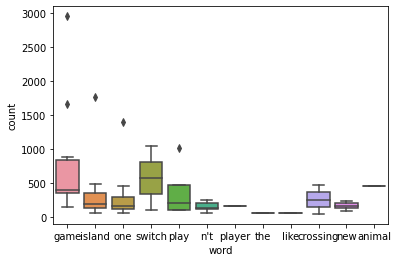

In [ ]:
sns.boxplot(x = "word", y = "count", data = word_count_by_grade)

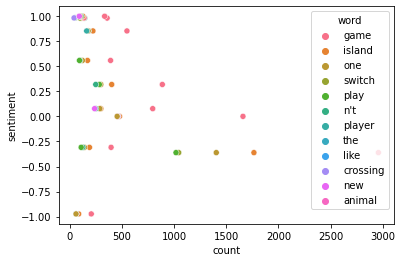

In [ ]:
sns.scatterplot(x = "count", y = "sentiment", data = word_count_by_grade, hue = "word")